<a href="https://colab.research.google.com/github/wkweigel/NotebookExamples/blob/main/3D_Alignment_and_Featurization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit py3Dmol tqdm mols2grid useful_rdkit_utils

#Clone main repository into colab
!git clone https://github.com/wkweigel/NotebookExamples.git
import sys
#Add directories to the path
main_dir = '/content/NotebookExamples'
sys.path.insert(0,f'{main_dir}/')

from Modules.DataframeUtils import*
from Modules.ConfGen import*
from rdkit.Chem import AllChem, Draw, rdMolAlign, PandasTools, rdFMCS, rdMolDescriptors
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.7 MB/s eta 0:00:00
Cloning into 'NotebookExamples'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 355 (delta 129), reused 137 (delta 77), pack-reused 116 (from 1)
Receiving objects: 100% (355/355), 18.36 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (182/182), done.


# Load the Data
In this example workflow we use DEL compounds that have a common "Building Block A" (A025, in this case).
* Since BB-A is shared, we can easily get a group of compounds that share a similar stucture and attempt to align the structures.

#### Get a dataframe for the A025 building block compounds

In [2]:
dataset_df = pd.read_csv('/content/NotebookExamples/Datasets/Example_Library.csv')

#Use a boolean mask to get the rows with common BB A
bbA_mask = dataset_df['BB-A ID'] == 'A025'
bbA_df = dataset_df[bbA_mask]
bbA_df.head()

,Entry,DEL ID,BB-A ID,BB-B ID,DEL Smiles,BB-A Smiles,BB-B Smiles
8856,8857,A025_B001,A025,B001,CC(C)CC(N[C@@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)C(...,S(=O)(=O)(N)C=1(C=NN(C=1)CC(O)=O),O=C(O)CC(C)C
8857,8858,A025_B002,A025,B002,CCC=CCC(N[C@@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)C(...,S(=O)(=O)(N)C=1(C=NN(C=1)CC(O)=O),O=C(O)CC=CCC
8858,8859,A025_B003,A025,B003,CCC(C)CC(N[C@@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)C...,S(=O)(=O)(N)C=1(C=NN(C=1)CC(O)=O),O=C(O)CC(CC)C
8859,8860,A025_B004,A025,B004,CC(C)CCC(N[C@@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)C...,S(=O)(=O)(N)C=1(C=NN(C=1)CC(O)=O),O=C(O)CCC(C)C
8860,8861,A025_B005,A025,B005,CNC([C@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)NC(CC1CC...,S(=O)(=O)(N)C=1(C=NN(C=1)CC(O)=O),O=C(O)CC1(CCCC1)


# Sample Structures
Here we sample 10 structures that contain the same A025 building block.
* These will be the structures we use for alignment testing.

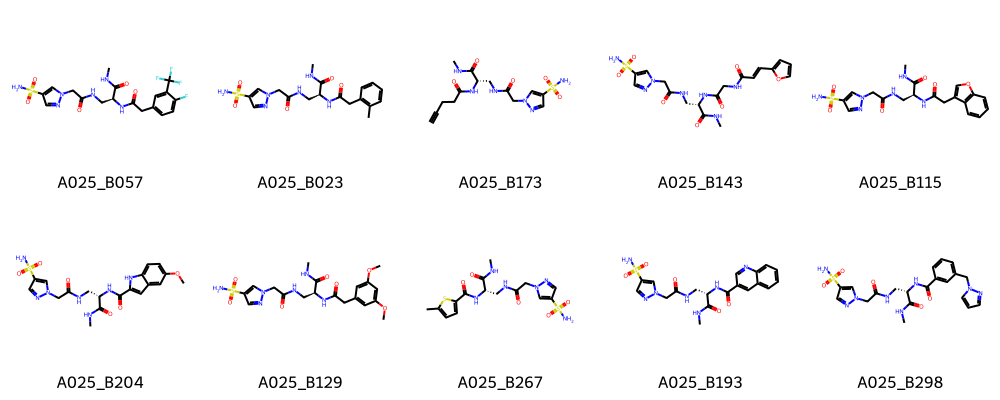

In [3]:
sample_df = bbA_df.sample(10)

#Use PandasTools to add mols to the sample_df
PandasTools.AddMoleculeColumnToFrame(sample_df, "DEL Smiles", "Mols")

# Preview the compounds
PandasTools.FrameToGridImage(sample_df, column='Mols', legendsCol="DEL ID", molsPerRow=5)

# Perform the Alignments
Align the test structures to the same reference compound (A025_B001)

In [5]:
# Create a custom conformer generator
generator = ConfGen()

#Get a refrence smiles
ref_smiles = bbA_df['DEL Smiles'].tolist()[0] # A025_B001 should be the first row
ref_mol= Chem.MolFromSmiles(ref_smiles)

#Add confs to the ref_mol
ref_mol, ref_mmff = generator.add_confs_to_mol(ref_mol)

#Add confs to the sample_df
sample_df = generator.add_confs_to_df(sample_df, 'DEL Smiles')

#Perform the alignments
generator.align_mols_to_ref(list(sample_df["Mols"]), ref_mol, list(sample_df["mmff"]), ref_mmff)



Embedding 3d Conformers:   0%|          | 0/10 [00:00<?, ?it/s]

Appliying Forcefields:   0%|          | 0/10 [00:00<?, ?it/s]

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Pharmacophore Featurization
Map the pharmacophore features for the mols in the sample_df

In [6]:
featLists = generator.map_feats(sample_df, 'Mols')

Visualize the 3D pharmacophores

In [7]:
drawmolfeats(list(sample_df["Mols"])[1],featLists[1])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
drawfeatsonly(list(sample_df["Mols"])[1],featLists[1])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.